# ロジスティック回帰

ベルヌーイ分布に従う変数の統計的回帰モデルの一種．主に二値分類で使われる．
ああああああああああああああああ

---
## scikit-learnでの出力

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, Image, Video
import time
import random

線形分離可能なデータセットを作成する．\
線形非分離な問題についても後で突っ込んでみたいね．
- 線形非分離
- from sklearn.datasets import make_gaussian_quantiles

参考
- https://plantprogramer.com/data_generator/

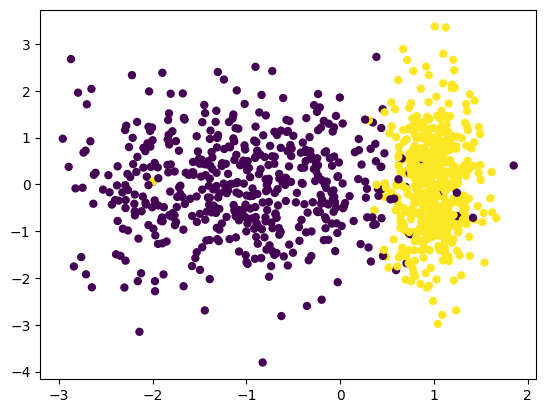

In [2]:
N = 1000 #データの数
d = 2 # 次元数
K = 2 # クラス数

X, y = make_classification(
    n_samples=N,
    n_features=d,
    n_informative=1,
    n_redundant=0,
    n_clusters_per_class=1,
    n_classes=K,
    random_state=20
)

plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, s=25) #c = yで色指定できる
plt.show()

本家skleanのLogisticRegressionではどのようなハイパーパラメータがあるかを確認

In [3]:
model = LogisticRegression(
    penalty=None,
    dual=False,
    tol=0.0001, #誤差の許容値，勾配降下のときに使うのかな？
    C = 1.0, # 正則化の強さ
    fit_intercept= False,# バイアス項を入れるかどうか，どのように影響するかはよくわからない
    intercept_scaling= 1.0, # solver='liblinear'でfit_intercept=Trueのときに発動
    class_weight=None, # クラスの数に応じて重みを受けることができる．
    random_state=None, # solver=['sag','saga','liblinear']のときにデータをシャッフルする．
    solver='newton-cg', # newton-cg を実装したい
    max_iter=100,
    multi_class='auto',
    verbose=0, # 冗長と訳せる，確かいらない
    warm_start=False, # 前のソリューションの値をそのまま持ってくる，でない場合はただ初期化するだけ
    n_jobs=None, # 使用するcpuのコア数
    l1_ratio=None # elasticnetのときの正則化割合，l1の割合を操作できる．
    )

In [4]:
start = time.time()
model.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)
print('クラス数',model.classes_)
print('特徴量の数',model.n_features_in_)
print('coef',model.coef_)
print('intercept',model.intercept_)
print('反復数',model.n_iter_)

実行時間 0.00903177261352539
クラス数 [0 1]
特徴量の数 2
coef [[3.62605703 0.07726773]]
intercept [0.]
反復数 [5]


In [5]:
pred = model.predict(X)
print(accuracy_score(y, pred))

0.942


- バイアス項の有無
- solverの違い

で出力が変わる．どう違うのかはよくわからぬ．

---
## 理論
ロジスティック回帰の気持ち，流れを先に整理する

### イメージで理解する

ベースは線形回帰なのでイメージをつかもう．\
線形回帰はざっくり以下のイメージ．

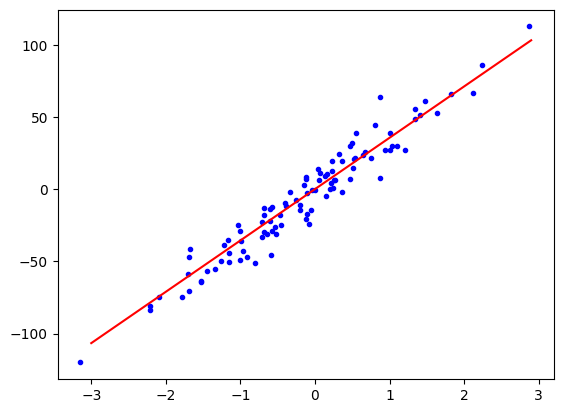

In [6]:
from sklearn.datasets import make_regression

x_reg, y_reg, coef_reg = make_regression(random_state = 12,
                       n_samples=100,
                       n_features=1,
                       n_informative=1,
                       noise=10.0,
                       bias=-0.0,
                       coef=True)

x0 = np.arange(-3, 3, 0.1)

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg, marker='.', color='blue')
plt.plot(x0, x0*coef_reg, color='red')
plt.plot()
plt.show()

これをうまく二値分類に適用することを考える．\
しかし，問題がある．**目的変数が二値であること**だ．\
って言われてもイメージがつきにくい．図で見るとこんな状況が発生している．

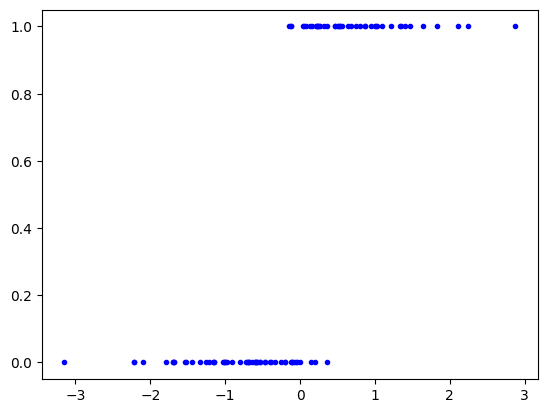

In [7]:
y_reg_0or1 = y_reg[:]

for i in range(len(y_reg_0or1)):
    if y_reg_0or1[i] > 0:
        y_reg_0or1[i] = 1
    else:
        y_reg_0or1[i] = 0

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg_0or1, marker='.', color='blue')
plt.plot()
plt.show()

これは一個前の図で$y$<0なら0，$y$>0なら1とした図である．(0,1には数値的な意味はない．ブール値のように捉えてほしい．)\
ここに線形回帰のように直線を引いて適切な予測ができるだろうか？\
どう考えても無理だろう．ということで何か良い方法を考える．\
そこで，線形回帰の直線を曲げることを考える．(ロジスティック変換)

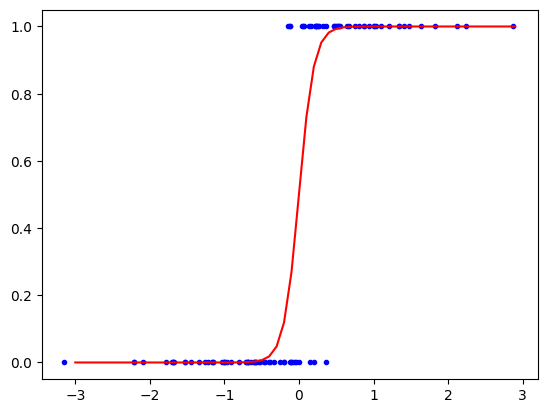

In [8]:
def sigmoid_method(x, gain):
    return 1 / (1 + np.exp(-x * gain))

sigmoid_x = np.arange(-3, 3, 0.1)

plt.figure
plt.subplot(1, 1, 1)
plt.scatter(x_reg, y_reg_0or1, marker='.', color='blue') #なぜかmarkerだけだと点が繋がる
plt.plot(sigmoid_x, sigmoid_method(sigmoid_x, gain=10), color='red')
plt.plot()
plt.show()

こんな感じ．\
実はこれはsigmoid関数を使っている．このようにして二値分類を実現する．\
ステップ関数でもいいじゃんとか思うかもしれないが，実装のときにステップ関数だとダメな理由がわかると思う．\
それに結局微分するのでステップ関数は使わない．

ひとまずイメージは掴めた．あとはどうやるのかを数学的に追うだけ．

### 数学で理解する

$n$:データ数\
$m$:次元数\
$X\in \mathbb{R}^{n\times m}$:説明変数\
$\boldsymbol{y}\in \mathbb{R}^{n\times 1}$:目的変数\
$\boldsymbol{w}\in \mathbb{R}^{m\times 1}$:パラメータ

今やったことを数式で説明しよう．\
まず線形回帰の式を用意する．
$$
X\boldsymbol{w}
$$
これだね．\
次にsigmoid関数を用意する．
$$
\sigma(x) = \frac{1}{1-e^{-x}}
$$
そしてsigmoid関数に線形回帰の式を代入する．
$$
\boldsymbol{\hat{y}} = \frac{1}{1-e^{-X\boldsymbol{w}}} \\
$$
これで出力値が**ほぼ二値**(0,1)のモデルができた．\
ほぼ二値なのはsigmoid関数の形を見れば明らか．\
そこで最終的にはsigmoid関数の出力を0.5を基準に二値に分ける操作が必要である．別に大したことではないね．

では，適切なパラメータ$\boldsymbol{w}$を求めていこう．\
しかし，(おそらく)最小二乗法は使えない．\
その理由を整理する．

目的変数は二値である．\
ということは予測値も二値で出力することになる．以下の損失関数は適切か？\
残差を$\boldsymbol{J}\in \mathbb{R}^{n×1}$とする．
$$
\begin{align}
\boldsymbol{J} &= \|\boldsymbol{y}-\boldsymbol{\hat{y}}\|_2^2 \\
&= \|\boldsymbol{y}-\frac{1}{1-e^{-X\boldsymbol{w}}} \|_2^2

\end{align}
$$
正直自分が数学ができないのでこれがダメな理由をはっきりということができない．\
しかし，少なくともこれよりも適切な損失関数は存在する．

※一応最小二乗法を使えない理由を一つ述べる．\
　最小二乗法は実測値$\boldsymbol{y}$が正規分布に従うと仮定して最尤推定を進めると出てくる手法である。\
　今回の目的変数は二値なので試行回数1回の二項分布，したがってベルヌーイ分布と捉えられる．\
　今回は実測値$\boldsymbol{y}$は正規分布だと仮定できないので，パラメータの点推定に**最尤法**を使用する．

細かいことは置いておいて，尤度を$L$としたとき，以下のようになる．\
二値データ$Y$が$Y=1$となる確率を$P=p(Y=1)$，$Y=0$となる確率を$1-P=p(Y=0)$とする．\
$Y(Y_1,Y_2,...,Y_N)$が独立であり，$p(Y_i=1)=P_i$であるとき尤度$L$は以下になる．\
※実測値を$Y$としているが，大文字であることに特に意味はない，ただ0,1しかとらないため，普段扱う連続値の$y$と区別したいため大文字にした．
$$
L = \prod_{i=1}^N P_i^{Y_i}(1-P_i)^{1-Y_i}
$$
$Y_i=1$のとき，$P_i^{Y_i}$が残って，$Y_i=0$のとき$(1-P_i)^{1-Y_i}$が残る．ただそれを表しているだけ．

お決まりのとおり対数尤度をとる．計算しやすいから．
$$
\begin{align}
log(L) &= log(\prod_{i=1}^N P_i^{Y_i}(1-P_i)^{1-Y_i}) \\
&= \sum_{i=1}^{N}(Y_i logP_i+(1-Y_i)log(1-P_i))\\
\end{align}
$$
この対数尤度を最大化する．\
$P_i$を以下とする．$\hat{y}_i$を$P_i$としたのは，確率と関係があるから．普通に予測値として捉えてもらって問題ない．
$$
P_i = \hat{y}_i = \sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)
$$
そして，負の対数尤度を$E(\boldsymbol{w})$として$E(\boldsymbol{w})$を最小化することを考える．
$$
E(\boldsymbol{w})=-\log (L) = \sum_{i=1}^{N}(Y_i \log \sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)+(1-Y_i)\log(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)))
$$
したがって，この最適値をニュートン法によって求める．
$$
\nabla E(\boldsymbol{w})=0
$$
を求めていく．(勾配が$0$になる点を求めていくということ．)\
ちなみに$\nabla E(\boldsymbol{w}^{old})$はただの一階微分

### ニュートン法

$$
\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})
$$
これがパラメータ$\boldsymbol{w}$の更新式である．これを繰り返すことで自ずと適切なパラメータが求められる．\
これを解いていくためには$H$，ヘッセ行列が必要である．

一旦，イメージが掴みやすいようにニュートン法によって$(x - 1)^2$の解を近似的に求めてみる．\
このときのニュートン法の式は以下
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}
$$

実際にニュートン法で$(x-1)^2$を近似してみる．\
ニュートン法の更新式の部分は具体的に以下のようになっている．
$$
x^{new} = x^{old} - \frac{(x-1)^2}{2x}
$$

In [9]:
x = 3.0
for i in range(1000):
    x_new = x - (x-1)**2 / (x * 2)
    if abs(x_new - x) < 0.000001:
        break
    x = x_new
print(x)

1.002012600455359


グラフにするとこれ(githubから動画は見れないので手元で実行してみて欲しい．)

In [11]:
# 近似したい関数
def here_function(x):
    y = (x - 1) ** 2
    return y

# 0を返すだけの関数，xの位置がわかりやすくするため．
def zero_function(x):
    return 0

def diff(diff ,x ,x0 ,intercept):
    return 2 * diff * (x-x0) + intercept

def here_function_derivative(x):
    return 2 * (x - 1)

start = 0 #定義域の左端
last = 6 # 定義域の右端

x0 = np.arange(start,last, 0.01)
y0 = here_function(x0)
x1 = np.arange(0,8, 0.01)

fig = plt.figure() # Figureオブジェクトを作成
ax = fig.add_subplot(1,1,1) # figに属するAxesオブジェクトを作成
#ax.set_aspect('equal')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.set_xlim(-1,7)
ax.set_ylim(-1,26)
ax.grid() # グラフにグリッドを追加


dx = 0.1
ax.plot(x0, y0)

artist_list = []
point_list_x = []
point_list_y = []
point_list_0 = []

x_ = 6.0
x_new = np.inf
for i in range(150):
    y_ = here_function(x_)
    zero = zero_function(x)

    # ニュートン法
    x_new = x_ - y_ / here_function_derivative(x_)
    if abs(x_new - x_) < 0.001:
        break
    point_list_x.append(x_)
    point_list_y.append(y_)
    point_list_0.append(zero)

    art = plt.plot(point_list_x, point_list_y, marker='.', markersize=10, color='red', linestyle='None')
    art += plt.plot(point_list_x, point_list_0, marker='.', markersize=10, color='red',linestyle='None')
    art += plt.plot(x1, diff(here_function_derivative(x_new),x1,x_, y_), marker='.',markersize=1 ,color='pink',linestyle='None')

    artist_list.append(art)
    x_ = x_new

ani = ArtistAnimation(fig, artist_list, interval = 200)

plt.close()
HTML(ani.to_jshtml())
# ani.save('anim.gif', writer="imagemagick")

ニュートン法のイメージが掴めた．ということで$\boldsymbol{w}^{new}$についても同様に理解したい．\
ニュートン法の式と今回使う式の対応を考えよう．\
今回の式は以下
$$
\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})
$$
ニュートン法の式は以下
$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}
$$
一見何が対応しているのかわからないが，整理していく．\
$H^{-1}$はヘッセ行列(二階微分)の逆行列であり．$\frac{1}{f'(x_1)}$に対応する．$f'(x)^{-1}$と書くとわかりやすい．\
$\nabla E(\boldsymbol{w}^{old})$はただの一階微分であり，$f(x_1)$に対応する．

今回は最終的に$\nabla E(\boldsymbol{w})\simeq 0$をニュートン法で目指している．

では，この更新式$\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})$に当てはまる具体的な数値を求めていこう．

### 具体的な数値へ展開

重みベクトル$\boldsymbol{w}$はベクトルとしてすでにある．\
わからないのは$H$と$\nabla E$だけ．こいつらを求める．そのために必要な材料は以下．
- シグモイド関数$\sigma$の微分}
- $E(\boldsymbol{w})$の一階微分(これが$\nabla E(\boldsymbol{w}$))

**シグモイド関数の微分**

$t=w^{T}x_i$とおく．
$$
\frac{d}{dt}\sigma(t) = (1+e^{-t})^{-1}
$$
ここで，$u=(1+e^{-t})$とおく．\
合成関数の微分より
$$
\begin{align}
\frac{d}{dt}\sigma(t)&=\frac{d}{du}u^{-1}\frac{du}{dt}u\\
&=-u^{-2}\frac{du}{dt}(1+e^{-t})\\
&=-(1+e^{-t})^{-2}\cdot-e^{-t}\\
\end{align}
$$
※補足としてe^{-t}の微分(わかっている人は次に進もう)\
T=-tとおく\
合成関数の微分より
$$
\begin{align}
\frac{d}{dt}(e^{-t})&=\frac{d}{dT}(e^{T})\frac{dT}{dt}T\\
&=e^{T}\frac{d}{dt}(-t)\\
&=e^{-t}\cdot-1\\
&=-e^{-t}
\end{align}
$$
さっきの途中から
$$
\begin{align}
\frac{d}{dt}\sigma(t)&=-(1+e^{-t})^{-2}\cdot-e^{-t}\\
&=\frac{e^{-t}}{(1+e^{-t})^{2}}\\
&=\frac{e^{-t}}{1+e^{-t}}\frac{1}{1+e^{-t}}\\
&=(\frac{1+e^{-t}}{1+e^{-t}}-\frac{1}{1+e^{-t}})\frac{1}{1+e^{-t}}\\
\frac{d}{dt}\sigma(t)&=(1-\sigma(t))\sigma(t)
\end{align}
$$
これでシグモイド関数の微分を求めることができた．(これは後々何回か出てくる．)

**$E(\boldsymbol{w})$の一階微分($\nabla E(\boldsymbol{w}$))**

$$
\nabla E(\boldsymbol w) = -\sum_{i=1}^n[Y_i\nabla\log \sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)+(1-Y_i)\nabla\log (1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))]
$$
$\frac{d}{dt}\log t=\frac1t$より
$$
= -\sum_{i=1}^n[Y_i\frac{1}{\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)}\nabla\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)
+
(1-Y_i)\frac{1}{1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)}\nabla (1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))]
$$
シグモイド関数の微分より
$$
\begin{align}
&= -\sum_{i=1}^n[Y_i\frac{1}{\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)}\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))\boldsymbol{x}_i^{T}
+
(1-Y_i)\frac{1}{1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)}(-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)))\boldsymbol{x}_i^{T}]\\

&= -\sum_{i=1}^n[Y_i(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))\boldsymbol{x}_i^{T}
+
(1-Y_i)(-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)\boldsymbol{x}_i^{T}]\\

&= -\sum_{i=1}^n[Y_i-Y_i\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)
-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)+Y_i\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)]\boldsymbol{x}_i^{T}\\

&= -\sum_{i=1}^n[Y_i-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)]\boldsymbol{x}_i^{T}\\

&= \sum_{i=1}^n(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-Y_i)\boldsymbol{x}_i^{T}\\
\end{align}
$$
$\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-Y_i$はスカラーで$\boldsymbol{x}_i^{T}$は$m$次元の行ベクトルである．したがって$\sum_{i=1}^n[\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-Y_i]\boldsymbol{x}_i^{T}$の意味は$\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-Y_i$倍された$\boldsymbol{x}_i^{T}$ベクトルをを$n$について足し合わせたものである．

行列を使用することで$\sum_{i=1}^n[\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-Y_i]\boldsymbol{x}_i^{T}$の$\sum$を消すことができる．そうすることでもっとシンプルに表すことができる．\
ここで表記を簡単にするために$\hat{y}_i=\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)$とする．上の方で$P_i=\hat{y}_i=\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)$とも言っていたけど，今回は予測値という意味合いがメインなので$\hat{y}$を使わせてもらう．
$$
\sum_{i=1}^n(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)-Y_i)\boldsymbol{x}_i^{T
}=\sum_{i=1}^n(\hat{y}_i-Y_i)\boldsymbol{x}_i^{T}\\
=\begin{bmatrix}
(\hat{y}_1-Y_1)x_{11} & (\hat{y}_1-Y_1)x_{12} & \cdots & (\hat{y}_1-Y_1)x_{1m}\\
&+&&\\
(\hat{y}_2-Y_2)x_{21} & (\hat{y}_2-Y_2)x_{22} & \cdots & (\hat{y}_2-Y_2)x_{2m}\\
&+&&\\
& \vdots &&\\
&+&&\\
(\hat{y}_n-Y_n)x_{n1} & (\hat{y}_n-Y_n)x_{n2} & \cdots & (\hat{y}_n-Y_n)x_{nm}\\
\end{bmatrix}
$$
これを行列$X$で表すと
$$
\nabla E(\boldsymbol{w})=X^{T}(\boldsymbol{\hat{y}}-\boldsymbol{Y})
$$
これで一階微分を求めることができた．

※補足
$$
\begin{align}
\frac{d}{d\boldsymbol{w}}\boldsymbol{w}^{T}\boldsymbol{x}
=\frac{d}{d\boldsymbol{w}}\boldsymbol{x}^{T}\boldsymbol{w}
&=
\frac{d}{d\boldsymbol{w}}
\begin{bmatrix}
x_1,&x_2,&\cdots&,x_m
\end{bmatrix}
\begin{bmatrix}
w_1\\ w_2 \\ \vdots\\ w_m
\end{bmatrix}\\
&=
\frac{d}{d\boldsymbol{w}}\begin{bmatrix}
x_1w_1+&x_2w_2+&\cdots&+x_mw_m
\end{bmatrix}\\
&=
\begin{bmatrix}
\frac{\partial}{\partial{w_1}}(x_1w_1+&x_2w_2+&\cdots&+x_mw_m)
,\frac{\partial}{\partial{w_2}}(x_1w_1+&x_2w_2+&\cdots&+x_mw_m)
,\cdots
,\frac{\partial}{\partial{w_m}}(x_1w_1+&x_2w_2+&\cdots&+x_mw_m)\\
\end{bmatrix}\\
&=
\begin{bmatrix}
x_1,&x_2,&\cdots&,x_m
\end{bmatrix}\\
&=
\boldsymbol{x}^{T}
\end{align}
$$

**ヘッセ行列$H$(二階微分)**

ヘッセ行列には厳密に説明があるが，今回は単純に「二階微分すればヘッセ行列ができる」とだけ意識して式変形していく．\
以下の式をたてる．

※この式の意味を順番に整理する．
- $H_{jk}$：ヘッセ行列の$j$行$k$列目の要素は右辺であることを表す．
- $w_k$：スカラーで$m×1$次元の$\boldsymbol{w}$ベクトルの要素を指す．(したがって$\frac{d}{dw_k}$は$\boldsymbol{w}$ベクトルの$k$番目の要素で微分するということ．)
- $\sum_{i=1}^{n}$：各行について計算し$n$行目まで足し合わせる．$X$について行方向について作用している，
- $(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i}-Y_i)x_{ij})$：$(予測値-実測値)×X$の$i$行$j$列目の要素\
これは行列で整理する前の一階微分の式と一緒．前は$\boldsymbol{x}^{T}$がついていたけど，今は$\boldsymbol{x}$の$j$番目を取り出しているので転置が外れているし，そもそもベクトルではなく，スカラーになっている．
$$
H_{jk}=\frac{d}{dw_k}[\sum_{i=1}^{n}((\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i})-Y_i)x_{ij})]
$$
突然$j,k$が出てきたがこれは$X$の$i$行$j,k$列目を考えたいがために出てきた文字である．特別$j,k$であることには意味はないし，どちらも$\boldsymbol{x}$の「〜番目の要素」を指定したいだけなので$j,k$を入れ替えても答えは一致する．$j,k$は区別されているほぼ同じものと捉えて問題ない．

整理できたのでいよいよ微分していく．
$$
\hat{y}=\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i})\\
g=\boldsymbol{w}^{T}\boldsymbol{x}_{i}\\とする．
$$
合成関数の微分より，
$$
\begin{align}
H_{jk}
&=\frac{d}{dw_k}[\sum_{i=1}^{n}(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i})x_{ij}-Y_ix_{ij})]\\
&=\sum_{i=1}^{n}\frac{d}{dw_k}[(\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_{i})x_{ij}-Y_ix_{ij})]\\
&=\sum_{i=1}^{n}\frac{d}{d\hat{y}}\frac{d\hat{y}}{dg}\frac{dg}{dw_k}\\
\end{align}
$$
順番に解いていく．
- $\frac{d}{d\hat{y}}$
$$
\frac{d}{d\hat{y}}=\frac{d}{d\hat{y}}\hat{y}x_{ij}-\frac{d}{d\hat{y}}Y_ix_{ij}\\
=x_{ij}\\
$$
- $\frac{d\hat{y}}{dg}$
$$
\frac{d\hat{y}}{dg}
=\frac{d\hat{y}}{dg}\hat{y}\\
=\frac{d\hat{y}}{dg}\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)\\
=\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))\\
$$
- $\frac{dg}{dw_k}$
$$
\frac{dg}{dw_k}=\frac{dg}{dw_k}g\\
=\frac{dg}{dw_k}\boldsymbol{w}^{T}\boldsymbol{x}_i\\
=\frac{dg}{dw_k}(w_1x_{i1}+w_2x_{i2}+\cdots+w_kx_{ik}+\cdots+w_mx_{im})\\
=x_{ik}
$$
3つ全て求められた．合体する．
$$
\begin{align}
H_{jk}
&=\sum_{i=1}^{n}\frac{d}{d\hat{y}}\frac{d\hat{y}}{dg}\frac{dg}{dw_k}\\
&=\sum_{i=1}^{n}x_{ij}\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i)(1-\sigma(\boldsymbol{w}^{T}\boldsymbol{x}_i))x_{ik}
\end{align}
$$
できた，しかし$\hat{y}$でおいた方がわかりやすいので置き換える．
$$
H_{jk}=\sum_{i=1}^{n}x_{ij}\hat{y}(1-\hat{y})x_{ik}
$$
ヘッセ行列の$jk$成分が求められた．\
$jk$成分が求められたので今度は$H$そのもの，ヘッセ行列全体を求める．\
$jk$成分を並べてヘッセ行列を求めてもいいのだが，すでにヘッセ行列は以下のように求められるとわかっている．\
対角行列$R$を以下とする．
$$
R=
\begin{pmatrix}
  \hat{y}_1(1-\hat{y}_1)                      \\
    &\hat{y}_2(1-\hat{y}_2)                  \\
    &&\ddots     \\
    &&&\hat{y}_n(1-\hat{y}_n)
\end{pmatrix}
$$
すると，ヘッセ行列は以下
$$
H=X^{T}RX
$$
これでヘッセ行列が求められた．

**ニュートン法で$\boldsymbol{w}$を求める**

材料はそろっている．

勾配(一階微分)
- $\nabla E(\boldsymbol{w})=X^{T}(\boldsymbol{\hat{y}}-\boldsymbol{Y})$

ヘッセ行列(二階微分)

- $H=X^{T}RX$

ニュートン法の式
- $\boldsymbol{w}^{new}=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})$

式に代入していく\
※以下の式変形は逆行列を作る,単位行列を作る,結合法則しか利用していないので補足は抜く，自分でどこをいじってるのか確認してみると良いかも．
$$
\begin{align}
\boldsymbol{w}^{new}
&=\boldsymbol{w}^{old}-H^{-1}\nabla E(\boldsymbol{w}^{old})\\
&=\boldsymbol{w}^{old}-(X^{T}RX)^{-1}X^{T}(\boldsymbol{\hat{y}}-\boldsymbol{Y})\\
&=(X^{T}RX)^{-1}X^{T}RX\boldsymbol{w}^{old}-(XRX^{T})^{-1}X^{T}RR^{-1}(\boldsymbol{\hat{y}}-\boldsymbol{Y})\\
&=(X^TRX)^{-1}(X^TR)[X\boldsymbol{w}^{old}-R^{-1}(\hat{y}-\boldsymbol{Y})]
\end{align}
$$
更新式が作れた．\
※実測値の$\boldsymbol{y}$が$Y$で書かれているが，$Y$はバイナリ変数のベクトルなので注意．行列ではない．

更新式(パラメータについての式)が求められたということは，実装できるということ．\
やってみよう．

---
# 実装
ポイントを以下に書く．
- パラメータ:$\boldsymbol{w}^{new} = (X^TRX)^{-1}(X^TR)[X\boldsymbol{w}^{old}-R^{-1}(\hat{y}-y)]$
- モデル:$\boldsymbol{\hat{y}} = \frac{1}{1-e^{-X\boldsymbol{w}}}$\
最終的な出力は二値なのでモデルの出力を0.5を基準に0と1に分けてあげて出力するといいかも．

## とりあえず自力で実装してみる

In [12]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def _predict(self, x):
        return self._sigmoid(x @ self.w)

    def _get_w(self, x, y, y_hat):
        for _ in range(X.shape[0]):
            self.R[_,_] = y_hat[_] * (1 - y_hat[_])
        xr = x.T @ self.R
        w_new = (np.linalg.pinv(xr @ x) @ xr) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y))
        diff = w_new - self.w
        return w_new, diff

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        for i in range(self.max_iter):
            y_hat = self._predict(x)
            w_new, diff = self._get_w(x, y, y_hat)
            if np.all(diff < tol_vec):
                break
            elif np.any(diff > tol_vec):
                self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [13]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 4.572922945022583
coef_ [3.62964304 0.0774151 ]
accuracy 0.942


大体一致してる．\
interceptないバージョンだからこれでよし

## 改良する

〜一旦答えを参考書の答えを見てみると...〜\
以下のような差があった．

1\. 全てのメソッドがfit,predictメソッドの中に入っている．\
2\. for文ではなくwhile文を使用している．\
3\. 逆行列はできるだけ計算せず，使うとしてもnp.linalg.solver()を使用している．\
4\. $R$は対角行列ではなく．$\boldsymbol r$ベクトルを使用している．

可読性，実行時間を良くするためにはこれらの工夫が必要．じゃあやってみる．

### fit, predictメソッドにまとめる．
冷静に順番にコードを追っていけば難しくない．

In [14]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        for i in range(self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.R[_,_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T @ self.R
            w_new = (np.linalg.pinv(xr @ x) @ xr) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y))
            diff = w_new - self.w
            if np.all(diff < tol_vec):
                break
            elif np.any(diff > tol_vec):
                self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [15]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 7.033288955688477
coef_ [3.62964534 0.07741521]
accuracy 0.942


### while文にする
for文の最後にbreakの条件があるので，それをwhile文の条件にすればいいだけ．\
あと．for文の繰り返し回数もwhile文のbreak条件にまとめれば完了．

diffは最初に何かしらの値にしないといけない．\
しかし確実にtol_vecより大きい値でないといけないのでinfに設定する．

繰り返し回数tol_を初期化する．\
tol_に1を加算していくことでwhileのbreak条件に使えるからね．

In [16]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        diff = np.full(x.shape[1], np.inf)
        tol_=0
        while np.any(diff > tol_vec) and (tol_ < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.R[_,_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T @ self.R
            w_new = (np.linalg.pinv(xr @ x) @ xr) @ (x @ self.w - np.linalg.pinv(self.R) @ (y_hat - y))
            diff = w_new - self.w
            tol_ += 1
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [17]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 5.834643840789795
coef_ [3.62964534 0.07741521]
accuracy 0.942


### np.linalg.invメソッドではなくnp.linalg.solverメソッドを使う
逆行列を求めて内積をとることと，単純に方程式を解くことは同義なので置き換えることができる．\
だからnp.dot(np.lingalg.inv(XRX),b)とnp.linalg.solve(XRX,b)は同じだよ.\
前者はこう．
$$
\boldsymbol{w}=XRX^{-1}\boldsymbol{b}
$$
後者はこれを$\boldsymbol{w}$について解く．
$$
XRX\boldsymbol{w}=\boldsymbol{b}
$$
ね，同じでしょ．\
でも後者の方が安定性などで勝るらしい．てことでこれを使う．

In [18]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.R = np.identity(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        diff = np.full(x.shape[1], np.inf)
        tol_=0
        while np.any(diff > tol_vec) and (tol_ < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.R[_,_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T @ self.R
            w_new = (np.linalg.solve(xr @ x, xr)) @ (x @ self.w - np.linalg.solve(self.R, (y_hat - y)))
            diff = w_new - self.w
            tol_ += 1
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > 0.5:
                y_pred[_] = 1
            elif y_pred[_] < 0.5:
                y_pred[_] = 0
        return y_pred

In [19]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 0.07617902755737305
coef_ [ -2.73883883 -13.55794056]
accuracy 0.424


めっちゃ早くなった．直接逆行列を求めないととても速くなる\
でもなんか失敗することが多い気がする...\
※以下のようなエラーのこと

In [20]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 0.0648660659790039
coef_ [-17.00942618 -34.29407372]
accuracy 0.325


### 逆行列を作らず．rベクトルを作ろう
取り掛かる前に，そんなことができるのか確認しよう．

**まず対角行列を作るバージョンから**

試しに$X$の代わりに3×4行列の$A$を作る．\
そして，4×4対角行列$R$も作る．

In [21]:
A = np.arange(1,13).reshape(3, 4)
R = np.diag(np.arange(1,4))

In [22]:
A

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [23]:
R

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

こんな行列たちね，で最後に内積$A^TR$を計算する．\
$A$の転置行列に$R$をかけると$A$の1列目は1倍に，$A$の2列目は2倍に，$A$の3列目は3倍になった．

In [24]:
AR = np.dot(A.T,R)
AR

array([[ 1, 10, 27],
       [ 2, 12, 30],
       [ 3, 14, 33],
       [ 4, 16, 36]])

**次はベクトルのバージョン**

次は$R$を対角行列ではなく，1×3行列(行ベクトル)$\boldsymbol r$として，内積ではなく普通の積を取る．

In [25]:
r = np.arange(1,4)
r

array([1, 2, 3])

In [26]:
Ar = A.T * r
Ar

array([[ 1, 10, 27],
       [ 2, 12, 30],
       [ 3, 14, 33],
       [ 4, 16, 36]])

ARとArの結果が同じになった．これでわざわざ対角行列を作らなくて済む．\
てことで組み込んでみる.

ポイントなのは，\
np.linalg.solve(self.R, (y_hat - y)　だったところが\
1 / self.r * (y_hat - y)　に置き換わっていること．

後者の方がシンプルで良い．

In [27]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.r = np.empty(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        diff = np.full(x.shape[1], np.inf)
        tol_=0
        while np.any(diff > tol_vec) and (tol_ < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.r[_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T * self.r
            w_new = np.dot((np.linalg.solve(np.dot(xr,x), xr)),
                           (np.dot(x, self.w) - (1 / self.r * (y_hat - y))))
            diff = w_new - self.w
            tol_ += 1
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > .5:
                y_pred[_] = 1
            elif y_pred[_] < .5:
                y_pred[_] = 0
        return y_pred

In [28]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 0.03657197952270508
coef_ [3.62964534 0.07741521]
accuracy 0.942


これで完了！\
エラー起きにくくなった気がしなくもない．気のせいかも．\
エラーの起きやすさに差があるのかは後で調べる．

### diffは使わず，self.wとtolとの差でwhile文をbreakする

In [29]:
class SLogisticRegression():
    def __init__(self, tol: float=0.0001, max_iter: int=100):
        self.tol = tol
        self.max_iter = max_iter

    @staticmethod
    def _sigmoid(Xw):
        return 1 / (1 + np.exp(-Xw))

    def fit(self, x, y):
        self.w = np.random.randn(x.shape[1])
        self.r = np.empty(x.shape[0])
        tol_vec = np.full(x.shape[1],self.tol)
        tol_=0
        while np.any(self.w > tol_vec) and (tol_ < self.max_iter):
            y_hat = self._sigmoid(x @ self.w)
            for _ in range(X.shape[0]):
                self.r[_] = y_hat[_] * (1 - y_hat[_])
            xr = x.T * self.r
            w_new = np.dot((np.linalg.solve(np.dot(xr,x), xr)),
                           (np.dot(x, self.w) - (1 / self.r * (y_hat - y))))
            tol_ += 1
            self.w = w_new

    def predict(self, x):
        y_hat_Xw = np.dot(x, self.w)
        y_pred = self._sigmoid(y_hat_Xw)
        for _ in range(x.shape[0]):
            if y_pred[_] > .5:
                y_pred[_] = 1
            elif y_pred[_] < .5:
                y_pred[_] = 0
        return y_pred

In [30]:
Smodel = SLogisticRegression(
    tol=0.0001,
    max_iter=100
)

start = time.time()
Smodel.fit(X,y)
end = time.time()
time_diff = end - start
print('実行時間',time_diff)

print("coef_",Smodel.w)
pred = Smodel.predict(X)
print("accuracy",accuracy_score(y, pred))

実行時間 0.08683204650878906
coef_ [3.62964534 0.07741521]
accuracy 0.942


---
# おまけ
感想やぼやきや疑問があったら書いていく．\
間違ったことを書く可能性大なので注意

### numpyのメソッドの優先順位について．

**避けたいランキング**\
1\.pinv (擬似逆行列)\
2\.inv (逆行列)\
3\.solver

### fit_interceptについて

logistic回帰にはfit_interceptハイパーパラメータがある．(logistic回帰に限った話ではないが)\
これは文字通りバイアス項を追加するかどうか.

fit_interceptの有無はどのように決めれば良いのだろうか．\
->fit_intercepはデータの性質で決める．例えば，回帰で被説明変数が負の値を取ることがおかしければfit_intercept=Falseにしたりする．\
　説明変数を全部0にしたときに目的変数が0を取るんだったらfit_intercept=Falseにすべき．